<a href="https://colab.research.google.com/github/Abhi-nand-shaji/Deep-Learning-Assignments/blob/main/Sentiment_Analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
test_path = "/content/drive/MyDrive/Assignment 3/test.csv"
train_path = "/content/drive/MyDrive/Assignment 3/train.csv"



In [ ]:
train_full_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [ ]:
print(train_full_df.head())
print("\nOriginal Train Dataset Size:", train_full_df.shape)
print("Test Dataset Size:", test_df.shape)


      id sentiment                                              tweet
0   4455  Negative                  tomorrow is a big day. #nervous  
1  17293  Negative  yesterday i won the prize for best paper prese...
2  29115  Negative  i am transforming. #i_am #positive #affirmatio...
3   6734  Negative  @user @user @user @user i know i was shocked!!...
4  21443  Positive    (advanced value chain videos at  ) #valuechain 

Original Train Dataset Size: (5600, 3)
Test Dataset Size: (1400, 3)


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
train_full_df['clean_tweet'] = train_full_df['tweet'].apply(clean_text)
test_df['clean_tweet'] = test_df['tweet'].apply(clean_text)

In [ ]:
label_map = {"Negative": 0, "Positive": 1}
train_full_df['label'] = train_full_df['sentiment'].map(label_map)
test_df['label'] = test_df['sentiment'].map(label_map)

In [ ]:
# Train/Val split
train_df, val_df = train_test_split(
    train_full_df,
    test_size=0.1,
    random_state=42,
    stratify=train_full_df['label']
)


print("\nTrain split size:", train_df.shape)
print("Validation split size:", val_df.shape)
print("Test split size:", test_df.shape)


Train split size: (5040, 5)
Validation split size: (560, 5)
Test split size: (1400, 5)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

def bert_tokenize(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df):
        self.texts = df['clean_tweet'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = bert_tokenize(self.texts[idx])
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
batch_size = 16
train_loader = DataLoader(BERTDataset(train_df), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(BERTDataset(val_df), batch_size=batch_size)
test_loader = DataLoader(BERTDataset(test_df), batch_size=batch_size)


In [ ]:
print("\nTrain split size:", train_df.shape)
print("Class Distribution in Balanced Train Data:\n", train_df['label'].value_counts())
print("Validation split size:", val_df.shape)
print("Class Distribution in Balanced Validation Data:\n", val_df['label'].value_counts())
print(train_df.head())
print(val_df.head())



Train split size: (5040, 5)
Class Distribution in Balanced Train Data:
 label
0    4690
1     350
Name: count, dtype: int64
Validation split size: (560, 5)
Class Distribution in Balanced Validation Data:
 label
0    521
1     39
Name: count, dtype: int64
         id sentiment                                              tweet  \
1633   5802  Negative   @user step out of the history that is holding...   
1887  30085  Negative  good morning i woke up this am w/ a bellamy br...   
233   21864  Negative  triumphant men's choir  father's day#"the powe...   
844   21723  Negative  why is every celebrity here when you can't go,...   
659    1409  Negative   @user feels good to be dancing again!   #newp...   

                                            clean_tweet  label  
1633  step out of the history that is holding you ba...      0  
1887  good morning i woke up this am w a bellamy bro...      0  
233   triumphant mens choir fathers daythe power of ...      0  
844   why is every celebrit

In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
sample_text = train_df['clean_tweet'].iloc[0]
encoding = tokenizer.encode_plus(sample_text, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())
print("\nSample cleaned tweet:")
print(sample_text)
print("\nTokens:")
print(tokens)


Sample cleaned tweet:
step out of the history that is holding you back step into the new story you are willing to create oprah winfrey lo

Tokens:
['[CLS]', 'step', 'out', 'of', 'the', 'history', 'that', 'is', 'holding', 'you', 'back', 'step', 'into', 'the', 'new', 'story', 'you', 'are', 'willing', 'to', 'create', 'op', '##rah', 'win', '##frey', 'lo', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [ ]:
epochs = 4
best_val_loss = float('inf')
patience = 3
no_improvement = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    all_preds, all_labels = [], []
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds)
    train_rec = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)

    model.eval()
    total_val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping triggered.")
            break




Epoch 1/4
Train Loss: 0.2127 | Accuracy: 0.9296 | Precision: 0.4823 | Recall: 0.1943 | F1: 0.2770
Val Loss: 0.1138 | Accuracy: 0.9661 | Precision: 0.7500 | Recall: 0.7692 | F1: 0.7595

Epoch 2/4
Train Loss: 0.1351 | Accuracy: 0.9554 | Precision: 0.7432 | Recall: 0.5457 | F1: 0.6293
Val Loss: 0.0992 | Accuracy: 0.9714 | Precision: 0.8710 | Recall: 0.6923 | F1: 0.7714

Epoch 3/4
Train Loss: 0.1034 | Accuracy: 0.9617 | Precision: 0.7540 | Recall: 0.6657 | F1: 0.7071
Val Loss: 0.0859 | Accuracy: 0.9696 | Precision: 0.7750 | Recall: 0.7949 | F1: 0.7848

Epoch 4/4
Train Loss: 0.0730 | Accuracy: 0.9754 | Precision: 0.8488 | Recall: 0.7857 | F1: 0.8160
Val Loss: 0.0837 | Accuracy: 0.9679 | Precision: 0.7692 | Recall: 0.7692 | F1: 0.7692


In [ ]:
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_prec = precision_score(test_labels, test_preds)
test_rec = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")

In [ ]:
model.save_pretrained("./bert_sentiment_model")
tokenizer.save_pretrained("./bert_sentiment_model")

('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.txt',
 './bert_sentiment_model/added_tokens.json')

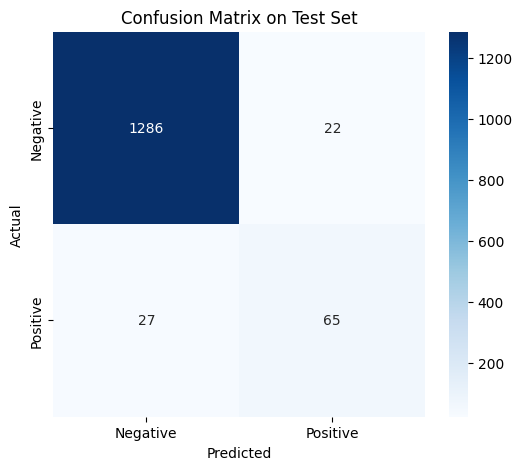

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report on Test Set:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Positive']))



Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98      1308
    Positive       0.75      0.71      0.73        92

    accuracy                           0.96      1400
   macro avg       0.86      0.84      0.85      1400
weighted avg       0.96      0.96      0.96      1400

